/tmp/ipython-input-3041547597.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2023-01-01", end="2025-01-01")["Close"].dropna()
[*********************100%***********************]  11 of 11 completed


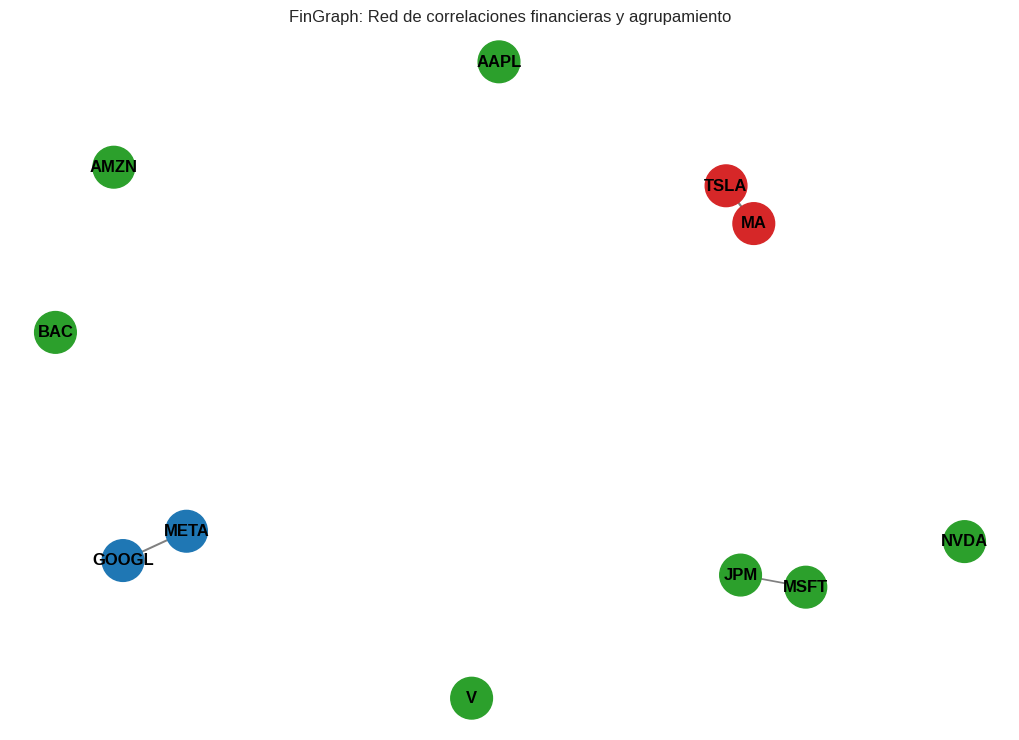

=== Agrupación de acciones según correlaciones ===
   Ticker  Cluster
2   GOOGL        0
4    META        0
1    MSFT        1
0    AAPL        1
3    AMZN        1
6    NVDA        1
7     JPM        1
8     BAC        1
9       V        1
5    TSLA        2
10     MA        2


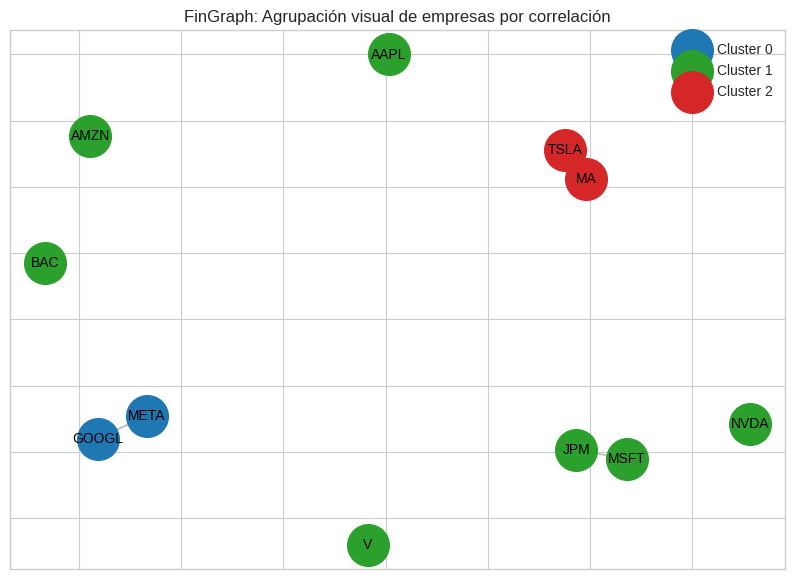

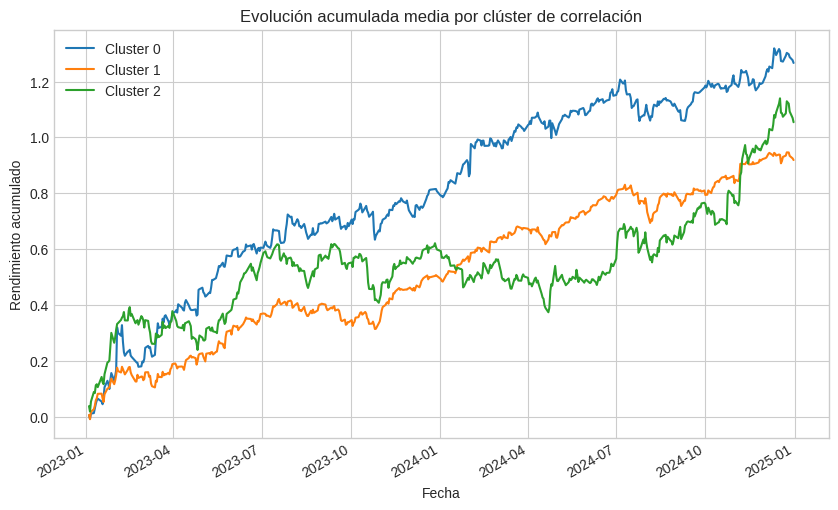


=== Métricas de la red ===
Grado medio: 0.55
Coeficiente de agrupamiento: 0.00
Diámetro aproximado: 1

=== Influencia de cada acción en la red ===
   Ticker  Centralidad  Cluster
1    MSFT          0.1        1
2   GOOGL          0.1        0
4    META          0.1        0
10     MA          0.1        2
5    TSLA          0.1        2
7     JPM          0.1        1
0    AAPL          0.0        1
6    NVDA          0.0        1
3    AMZN          0.0        1
8     BAC          0.0        1
9       V          0.0        1

=== Métricas promedio por clúster ===


,Cluster,Rentabilidad_media_anual,Volatilidad_anual
0,0,0.267412,0.235194
1,1,0.653232,0.358355
2,2,0.231377,0.163833


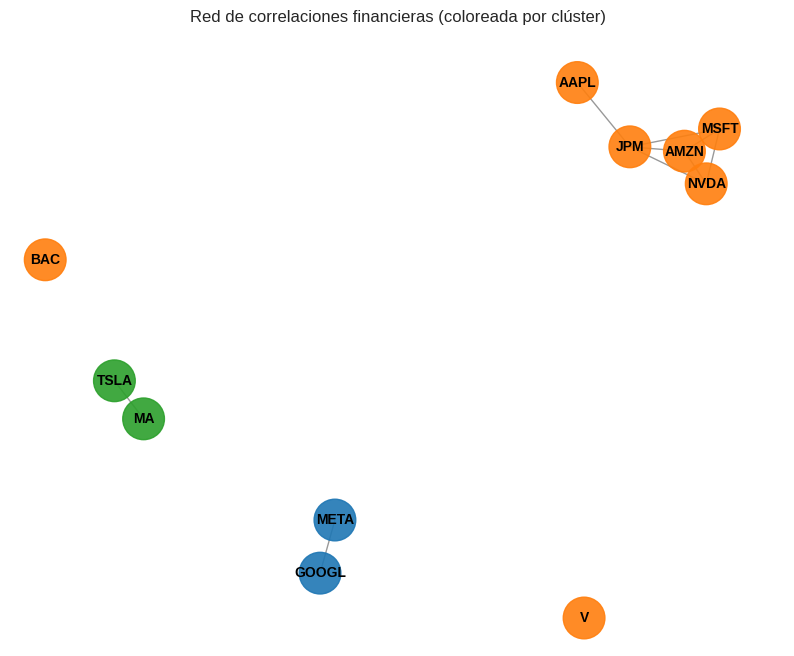


=== Ranking de influencia en la red financiera ===


,Ticker,Cluster,Degree,Betweenness,Eigenvector
0,JPM,1,0.4,0.066667,5.235630e-01
1,AMZN,1,0.3,0.000000,4.820444e-01
2,MSFT,1,0.3,0.000000,4.820444e-01
3,NVDA,1,0.3,0.000000,4.820444e-01
4,AAPL,1,0.1,0.000000,1.696503e-01
5,GOOGL,0,0.1,0.000000,2.482683e-06
6,META,0,0.1,0.000000,2.482683e-06
7,TSLA,2,0.1,0.000000,2.482683e-06
8,MA,2,0.1,0.000000,2.482683e-06
9,BAC,1,0.0,0.000000,1.894137e-11


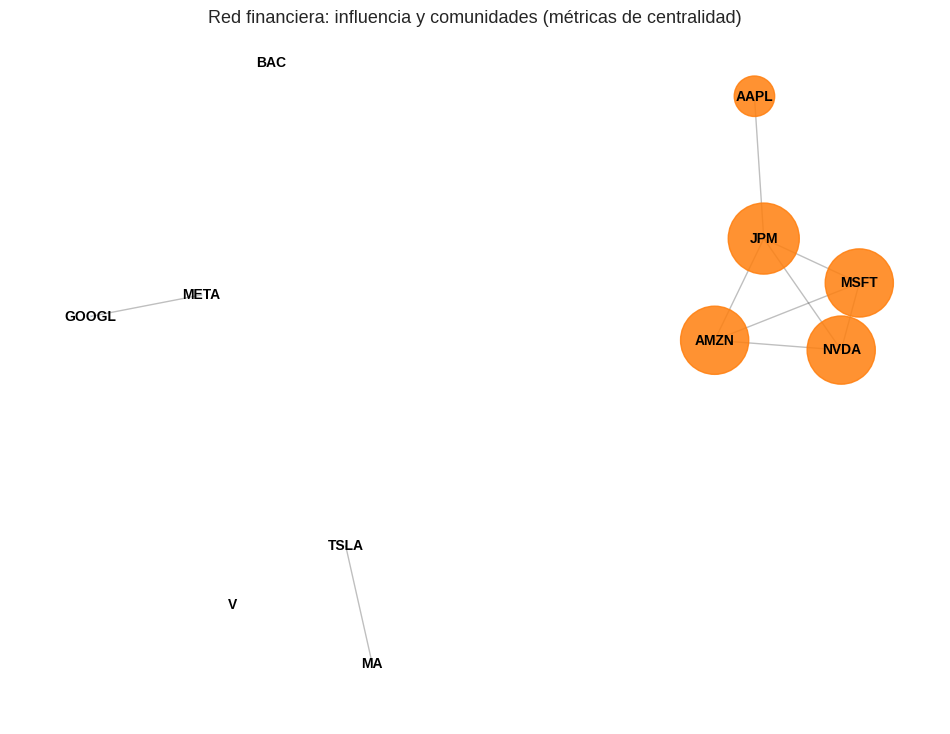

In [9]:
# ============================================
# FinGraph: Red de correlaciones financieras
# ============================================

import yfinance as yf
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib as mpl

plt.style.use("seaborn-v0_8-whitegrid")

# ============================================
# 1. Descarga de datos
# ============================================
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NVDA", "JPM", "BAC", "V", "MA"]
data = yf.download(tickers, start="2023-01-01", end="2025-01-01")["Close"].dropna()

# ============================================
# 2. Cálculo de rendimientos y correlaciones
# ============================================
returns = data.pct_change().dropna()
corr_matrix = returns.corr()

# ============================================
# 3. Creación del grafo según correlaciones
# ============================================
threshold = 0.6
edges = np.where(corr_matrix.values > threshold)

G = nx.Graph()
for i, t in enumerate(tickers):
    G.add_node(i, label=t)

for i, j in zip(*edges):
    if i < j:
        G.add_edge(i, j, weight=corr_matrix.values[i, j])

# ============================================
# 4. Clustering de acciones según correlación
# ============================================
X = corr_matrix.values
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

color_palette = ['#1f77b4', '#2ca02c', '#d62728']
node_colors = [color_palette[labels[i]] for i in range(len(tickers))]

# ============================================
# 5. Visualización básica del grafo
# ============================================
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)
weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, labels={i:t for i,t in enumerate(tickers)},
        node_color=node_colors, node_size=900, edge_color="gray", width=weights, font_weight="bold")
plt.title("FinGraph: Red de correlaciones financieras y agrupamiento")
plt.show()

# ============================================
# 6. Análisis de clusters
# ============================================
clusters = pd.DataFrame({
    "Ticker": tickers,
    "Cluster": labels
}).sort_values(by="Cluster")

print("=== Agrupación de acciones según correlaciones ===")
print(clusters)

# ============================================
# 7. Visualización por clúster
# ============================================
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)
for c in np.unique(labels):
    nx.draw_networkx_nodes(G, pos, nodelist=[i for i in range(len(tickers)) if labels[i]==c],
                           node_color=color_palette[c], label=f"Cluster {c}", node_size=900)
nx.draw_networkx_edges(G, pos, edge_color="gray", width=weights, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={i:t for i,t in enumerate(tickers)}, font_size=10)
plt.title("FinGraph: Agrupación visual de empresas por correlación")
plt.legend()
plt.show()

# ============================================
# 8. Evolución temporal media por clúster
# ============================================
ticker_to_cluster = {tickers[i]: labels[i] for i in range(len(tickers))}
cluster_groups = {}
for c in np.unique(labels):
    cluster_tickers = [t for t, cl in ticker_to_cluster.items() if cl == c]
    cluster_groups[c] = returns[cluster_tickers].mean(axis=1)

mean_by_cluster = pd.DataFrame(cluster_groups)

(mean_by_cluster.cumsum()).plot(figsize=(10,6))
plt.title("Evolución acumulada media por clúster de correlación")
plt.ylabel("Rendimiento acumulado")
plt.xlabel("Fecha")
plt.legend([f"Cluster {i}" for i in mean_by_cluster.columns])
plt.show()

# ============================================
# 9. Métricas de red
# ============================================
print("\n=== Métricas de la red ===")
print(f"Grado medio: {np.mean([d for _, d in G.degree()]):.2f}")
print(f"Coeficiente de agrupamiento: {nx.average_clustering(G):.2f}")
print(f"Diámetro aproximado: {nx.diameter(G.subgraph(max(nx.connected_components(G), key=len)))}")

# ============================================
# 10. Centralidad
# ============================================
centrality = nx.degree_centrality(G)
central_df = pd.DataFrame({
    'Ticker': tickers,
    'Centralidad': [centrality[i] for i in range(len(tickers))],
    'Cluster': labels
}).sort_values(by='Centralidad', ascending=False)

print("\n=== Influencia de cada acción en la red ===")
print(central_df)

# ============================================
# 11. Métricas financieras por clúster
# ============================================
mean_returns = returns.mean() * 252
volatility = returns.std() * np.sqrt(252)

metrics = pd.DataFrame({
    "Ticker": tickers,
    "Cluster": labels,
    "Rentabilidad_media_anual": mean_returns.values,
    "Volatilidad_anual": volatility.values
})

cluster_summary = metrics.groupby("Cluster")[["Rentabilidad_media_anual", "Volatilidad_anual"]].mean().reset_index()
print("\n=== Métricas promedio por clúster ===")
display(cluster_summary)

# ============================================
# 12. Grafo financiero final
# ============================================
G = nx.Graph()
for i, t in enumerate(tickers):
    G.add_node(t, cluster=labels[i])
for i, t1 in enumerate(tickers):
    for j, t2 in enumerate(tickers):
        if i < j and abs(corr_matrix.iloc[i, j]) > 0.5:
            G.add_edge(t1, t2, weight=corr_matrix.iloc[i, j])

color_map = mpl.colormaps.get_cmap("tab10")
node_colors = [color_map(G.nodes[t]['cluster']) for t in G.nodes()]

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=900, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
plt.title("Red de correlaciones financieras (coloreada por clúster)")
plt.axis("off")
plt.show()

# ============================================
# 13. Centralidad y riesgo sistémico
# ============================================
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

centrality_df = pd.DataFrame({
    "Ticker": list(G.nodes()),
    "Cluster": [G.nodes[t]['cluster'] for t in G.nodes()],
    "Degree": [degree_centrality[t] for t in G.nodes()],
    "Betweenness": [betweenness_centrality[t] for t in G.nodes()],
    "Eigenvector": [eigenvector_centrality[t] for t in G.nodes()]
}).sort_values(by="Eigenvector", ascending=False).reset_index(drop=True)

print("\n=== Ranking de influencia en la red financiera ===")
display(centrality_df.head(10))

# ============================================
# 14. Visualización avanzada del riesgo sistémico
# ============================================
sizes = [5000 * centrality_df.set_index("Ticker").loc[t, "Eigenvector"] for t in G.nodes()]
node_colors = [color_map(G.nodes[t]['cluster']) for t in G.nodes()]

plt.figure(figsize=(12,9))
pos = nx.spring_layout(G, seed=42, k=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=sizes, alpha=0.85)
nx.draw_networkx_edges(G, pos, alpha=0.25)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
plt.title("Red financiera: influencia y comunidades (métricas de centralidad)", fontsize=13)
plt.axis("off")
plt.show()
